In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf

In [2]:
dir = "C:/Users/user/Desktop/easyOCR_LL/image"
fname = sorted(os.listdir(dir))
fname = sorted([os.path.join(dir, fname) 
                            for fname in os.listdir(dir)
                            if fname.endswith('.jpg')])

In [9]:
fname[0][-5]
ko = []
en = []
ch = []
num = []
extra = []
miss = []

for i in fname:
    if i[-5] == '1':
        ko.append(i)
    elif i[-5] == '2':
        en.append(i)
    elif i[-5] == '3':
        ch.append(i)
    elif i[-5] == '4':
        num.append(i)
    elif i[-5] == '5':
        extra.append(i)
    elif i[-5] == '6':
        miss.append(i)

In [12]:
print(len(ko))
print(len(en))
print(len(ch))
print(len(num))
print(len(extra))
print(len(miss))

14573
1673
1895
2534
0
672


In [24]:
data = ko[0:1500] + en[0:1500] + ch[0:1500] + num[0:1500]
len(data)

6000

In [28]:
target = []
for i in range(0, len(data)):
    temp = data[i][-5]
    temp = int(temp)
    target.append(temp-1)
len(target)

6000

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, stratify=target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [30]:
import tensorflow as tf

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img /= 255.0
    return img

img_size = 128

x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_val = tf.data.Dataset.from_tensor_slices(x_val)
x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_val = tf.data.Dataset.from_tensor_slices(y_val)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

x_train = x_train.map(load_and_preprocess_image)
x_val = x_val.map(load_and_preprocess_image)
x_test = x_test.map(load_and_preprocess_image)
y_train = y_train.map(int)
y_val = y_val.map(int)
y_test = y_test.map(int)

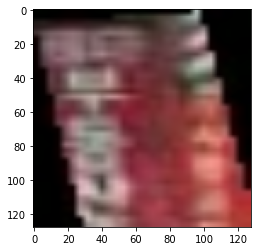

In [34]:
from matplotlib import pyplot as plt

for img in list(x_train.take(1)):
    plt.imshow(img)

In [60]:
from keras.applications.vgg16 import VGG16
from keras import layers
 
def build_model():
    tf.random.set_seed(2)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(128, 128, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

model = build_model()

In [61]:
# Identity Block
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
 
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
 
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
 
        self.relu = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
 
        x = self.conv2(x)
        x = self.bn2(x)
 
        x = self.add([x, inputs])
        x = self.relu(x)
 
        return x
    
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
 
        x = self.id1a(x)
        x = self.id1b(x)
 
        x = self.global_pool(x)
        return self.classifier(x)
    


In [62]:
model = ResNet(6)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
               metrics=['acc'])

In [63]:
train_ds = tf.data.Dataset.zip((x_train, y_train))
train_ds = train_ds.cache().batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = tf.data.Dataset.zip((x_val, y_val))
val_ds = val_ds.cache().batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.zip((x_test, y_test))
test_ds = test_ds.cache().batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [64]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
60/60 [==============================] - 16s 263ms/step - loss: 1.4896 - acc: 0.3531 - val_loss: 1.6729 - val_acc: 0.2542
Epoch 2/30
60/60 [==============================] - 16s 272ms/step - loss: 1.2723 - acc: 0.4034 - val_loss: 1.5057 - val_acc: 0.2667
Epoch 3/30
60/60 [==============================] - 14s 232ms/step - loss: 1.2343 - acc: 0.4182 - val_loss: 1.5387 - val_acc: 0.2948
Epoch 4/30
60/60 [==============================] - 14s 231ms/step - loss: 1.2058 - acc: 0.4424 - val_loss: 1.5964 - val_acc: 0.3135
Epoch 5/30
60/60 [==============================] - 15s 261ms/step - loss: 1.1874 - acc: 0.4461 - val_loss: 1.6262 - val_acc: 0.3469
Epoch 6/30
60/60 [==============================] - 15s 259ms/step - loss: 1.1765 - acc: 0.4570 - val_loss: 2.0532 - val_acc: 0.3198
Epoch 7/30
60/60 [==============================] - 14s 230ms/step - loss: 1.1645 - acc: 0.4620 - val_loss: 1.4606 - val_acc: 0.3948
Epoch 8/30
60/60 [==============================] - 15s 255ms/step - 

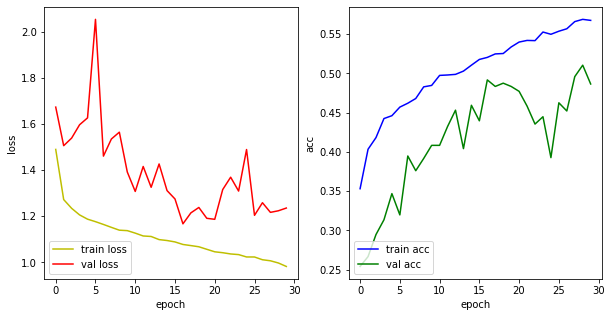

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(history.history['loss'], 'y', label='train loss')
axes[0].plot(history.history['val_loss'], 'r', label='val loss')

axes[1].plot(history.history['acc'], 'b', label='train acc')
axes[1].plot(history.history['val_acc'], 'g', label='val acc')

axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('acc')

axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')

plt.show()

In [66]:
model.evaluate(test_ds)

19/19 [==============================] - 1s 30ms/step - loss: 1.2571 - acc: 0.4825


[1.2570637464523315, 0.48249998688697815]

In [67]:
result = model.predict(test_ds)
# result = np.argmax(result, axis=-1)

In [68]:
np.set_printoptions(precision=6, suppress=True)
result[10:15]

array([[0.05336 , 0.110464, 0.832501, 0.003604, 0.000029, 0.000042],
       [0.514675, 0.234242, 0.246703, 0.004319, 0.00003 , 0.00003 ],
       [0.061724, 0.14297 , 0.785085, 0.01016 , 0.00002 , 0.00004 ],
       [0.012247, 0.305661, 0.004119, 0.677947, 0.000011, 0.000015],
       [0.011165, 0.726951, 0.11013 , 0.151694, 0.000014, 0.000046]],
      dtype=float32)

In [73]:
print(test_ds.take(0))
print(result.argmax(axis=-1)[0:20])

<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
[2 3 3 3 2 3 1 1 0 2 2 0 2 3 1 1 2 3 1 0]


In [83]:
list(test_ds)

[(<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
  array([[[[0.      , 0.011765, 0.      ],
           [0.      , 0.011765, 0.      ],
           [0.000184, 0.011581, 0.      ],
           ...,
           [0.043137, 0.      , 0.      ],
           [0.043137, 0.      , 0.      ],
           [0.043137, 0.      , 0.      ]],
  
          [[0.00046 , 0.011612, 0.      ],
           [0.00046 , 0.011612, 0.      ],
           [0.001038, 0.011808, 0.000244],
           ...,
           [0.050993, 0.007535, 0.00264 ],
           [0.05095 , 0.007506, 0.002604],
           [0.05095 , 0.007506, 0.002604]],
  
          [[0.004688, 0.010202, 0.      ],
           [0.004688, 0.010202, 0.      ],
           [0.0089  , 0.0139  , 0.00249 ],
           ...,
           [0.123264, 0.076855, 0.026929],
           [0.122825, 0.076563, 0.026563],
           [0.122825, 0.076563, 0.026563]],
  
          ...,
  
          [[0.151777, 0.090625, 0.034375],
           [0.151777, 0.090625, 0.034375],
 